In [1]:
import arviz as az
import matplotlib
import numpy as np
import pymc as pm
import aesara.tensor as at
import scipy as sp
import seaborn as sns
import xarray as xr

from matplotlib import pyplot as plt
from matplotlib.lines import Line2D
from numpy.random import default_rng
from xarray_einstats import linalg
from xarray_einstats.stats import XrContinuousRV


WARNING (aesara.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
n = 250
k_true = 4
d = 10

In [ ]:
k = 2

coords = {"latent_columns": np.arange(k), "rows": np.arange(n), "observed_columns": np.arange(d)}

with pm.Model(coords=coords) as PPCA:
    W = pm.Normal("W", dims=("observed_columns", "latent_columns"))
    F = pm.Normal("F", dims=("latent_columns", "rows"))
    psi = pm.HalfNormal("psi", 1.0)
    X = pm.Normal("X", mu=at.dot(W, F), sigma=psi, observed=Y, dims=("observed_columns", "rows"))

    trace = pm.sample(tune=2000, random_seed=RANDOM_SEED)  # target_accept=0.9

In [1]:
import pandas as pd

In [3]:
pd.read_csv('tmp_fake_csv',header=['subject','k','train acc','val acc','test acc'])

ValueError: header must be integer or list of integers

# factor analysis test

In [6]:
import arviz as az
import matplotlib
import numpy as np
import pymc as pm
import aesara.tensor as at
import scipy as sp
import seaborn as sns
import xarray as xr

from matplotlib import pyplot as plt
from matplotlib.lines import Line2D
from numpy.random import default_rng
from xarray_einstats import linalg
from xarray_einstats.stats import XrContinuousRV

print(f"Running on PyMC v{pm.__version__}")

Running on PyMC v4.2.2


In [7]:
%config InlineBackend.figure_format = 'retina'
az.style.use("arviz-darkgrid")

np.set_printoptions(precision=3, suppress=True)
RANDOM_SEED = 31415
rng = default_rng(RANDOM_SEED)


In [8]:
n = 250
k_true = 4
d = 10

In [9]:
err_sd = 2
M = rng.binomial(1, 0.25, size=(k_true, n))
Q = np.hstack([rng.exponential(2 * k_true - k, size=(d, 1)) for k in range(k_true)]) * rng.binomial(
    1, 0.75, size=(d, k_true)
)
Y = np.round(1000 * np.dot(Q, M) + rng.standard_normal(size=(d, n)) * err_sd) / 1000

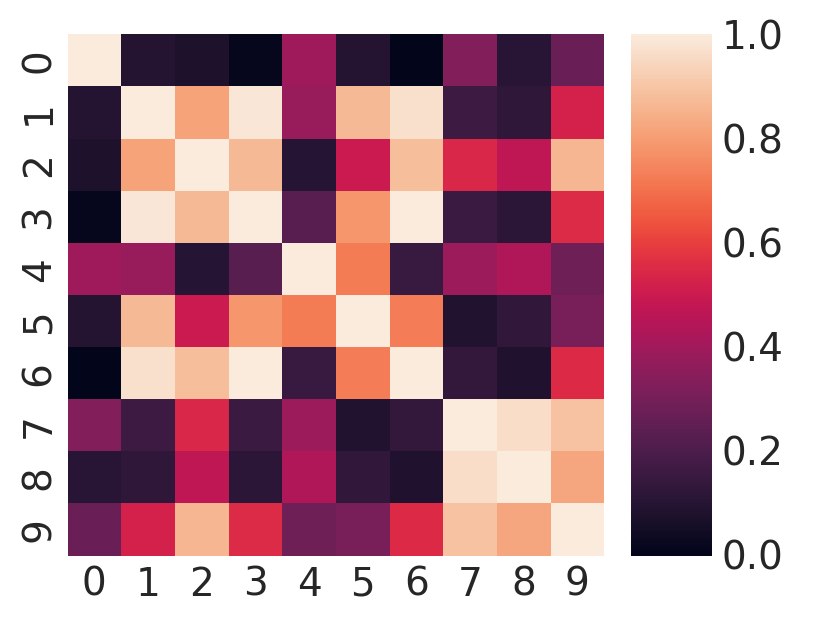

In [10]:
plt.figure(figsize=(4, 3))
sns.heatmap(np.corrcoef(Y))

In [13]:
k = 2

coords = {"latent_columns": np.arange(k), "rows": np.arange(n), "observed_columns": np.arange(d)}

with pm.Model(coords=coords) as PPCA:
    W = pm.Normal("W", dims=("observed_columns", "latent_columns"))
    F = pm.Normal("F", dims=("latent_columns", "rows"))
    psi = pm.HalfNormal("psi", 1.0)
    X = pm.Normal("X", mu=at.dot(W, F), sigma=psi, observed=Y, dims=("observed_columns", "rows"))

    trace = pm.sample(tune=2000, random_seed=RANDOM_SEED)  # target_accept=0.9

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [W, F, psi]


Sampling 2 chains for 2_000 tune and 1_000 draw iterations (4_000 + 2_000 draws total) took 42 seconds.
There were 755 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.1299, but should be close to 0.8. Try to increase the number of tuning steps.
Sampling 2 chains for 2_000 tune and 1_000 draw iterations (4_000 + 2_000 draws total) took 36 seconds.
There were 755 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.1299, but should be close to 0.8. Try to increase the number of tuning steps.


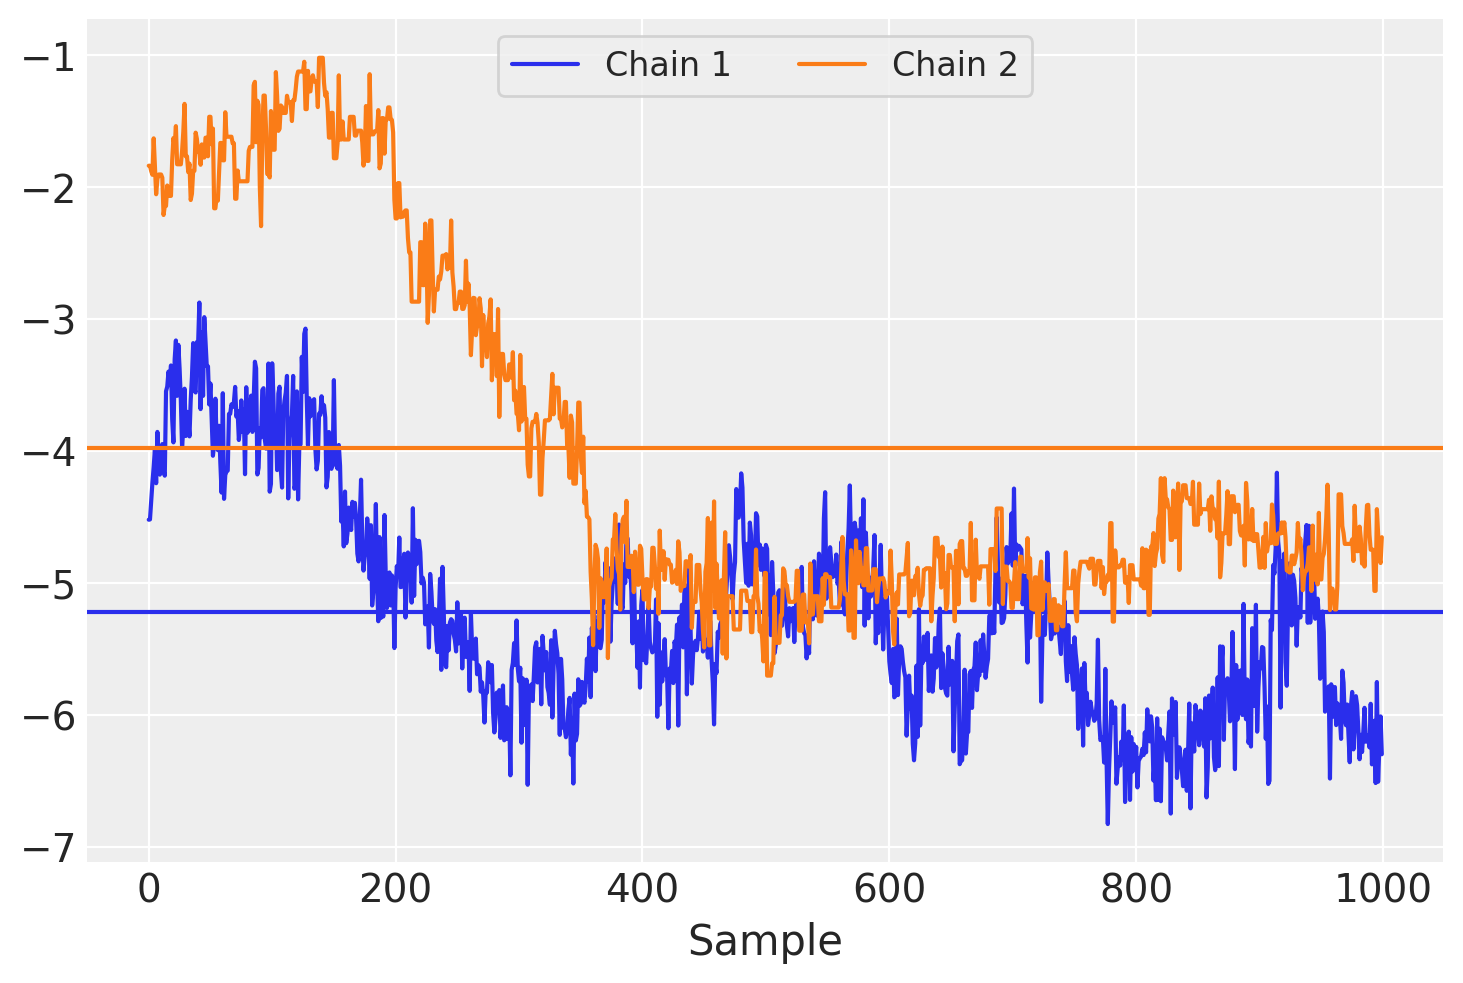

In [14]:
for i in trace.posterior.chain.values:
    samples = trace.posterior["W"].sel(chain=i, observed_columns=3, latent_columns=1)
    plt.plot(samples, label="Chain {}".format(i + 1))
    plt.axhline(samples.mean(), color=f"C{i}")
plt.legend(ncol=4, loc="upper center", fontsize=12, frameon=True), plt.xlabel("Sample");

In [15]:
def expand_packed_block_triangular(d, k, packed, diag=None, mtype="pytensor"):
    # like expand_packed_triangular, but with d > k.
    assert mtype in {"pytensor", "numpy"}
    assert d >= k

    def set_(M, i_, v_):
        if mtype == "pytensor":
            return at.set_subtensor(M[i_], v_)
        M[i_] = v_
        return M

    out = at.zeros((d, k), dtype=float) if mtype == "pytensor" else np.zeros((d, k), dtype=float)
    if diag is None:
        idxs = np.tril_indices(d, m=k)
        out = set_(out, idxs, packed)
    else:
        idxs = np.tril_indices(d, k=-1, m=k)
        out = set_(out, idxs, packed)
        idxs = (np.arange(k), np.arange(k))
        out = set_(out, idxs, diag)
    return out

In [16]:
def makeW(d, k, dim_names):
    # make a W matrix adapted to the data shape
    n_od = int(k * d - k * (k - 1) / 2 - k)

    # trick: the cumulative sum of z will be positive increasing
    z = pm.HalfNormal("W_z", 1.0, dims="latent_columns")
    b = pm.HalfNormal("W_b", 1.0, shape=(n_od,), dims="packed_dim")
    L = expand_packed_block_triangular(d, k, b, at.ones(k))
    W = pm.Deterministic("W", at.dot(L, at.diag(at.extra_ops.cumsum(z))), dims=dim_names)
    return W

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [W_z, W_b, F, psi]


Sampling 2 chains for 2_000 tune and 1_000 draw iterations (4_000 + 2_000 draws total) took 49 seconds.


KeyError: "not all values found in index 'chain'. Try setting the `method` keyword argument (example: method='nearest')."

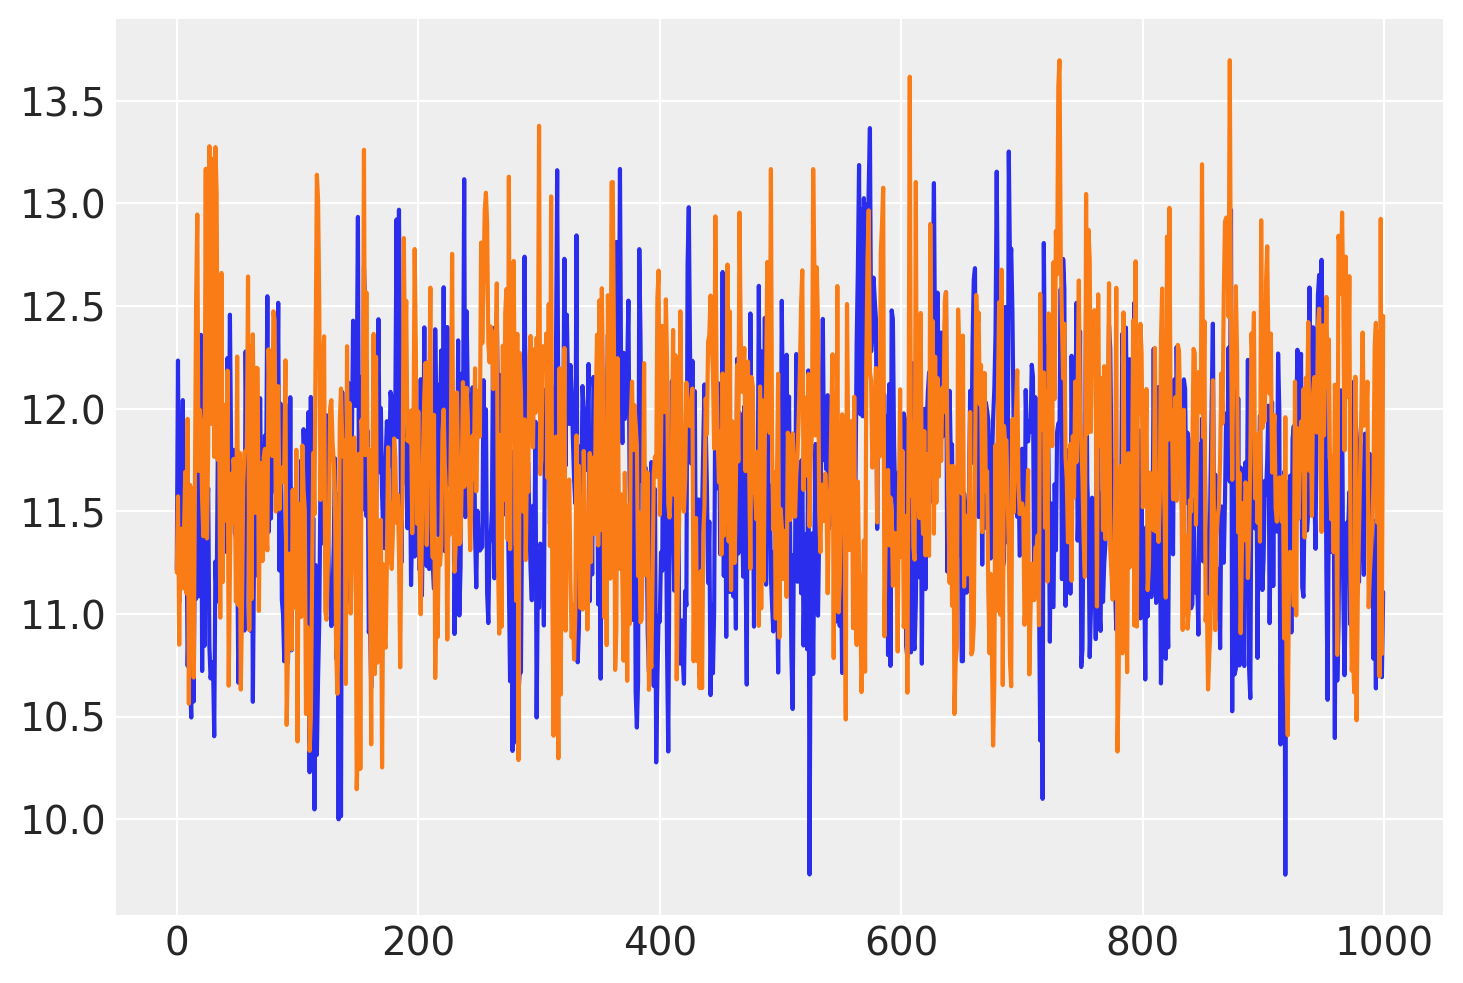

In [17]:
with pm.Model(coords=coords) as PPCA_identified:
    W = makeW(d, k, ("observed_columns", "latent_columns"))
    F = pm.Normal("F", dims=("latent_columns", "rows"))
    psi = pm.HalfNormal("psi", 1.0)
    X = pm.Normal("X", mu=at.dot(W, F), sigma=psi, observed=Y, dims=("observed_columns", "rows"))
    trace = pm.sample(tune=2000)  # target_accept=0.9

for i in range(4):
    samples = trace.posterior["W"].sel(chain=i, observed_columns=3, latent_columns=1)
    plt.plot(samples, label="Chain {}".format(i + 1))

plt.legend(ncol=4, loc="lower center", fontsize=8), plt.xlabel("Sample");

In [19]:
gv = pm.model_to_graphviz(PPCA_identified)
gv.view('PPCA_identified_test')

'PPCA_identified_test.pdf'

In [18]:
coords["observed_columns2"] = coords["observed_columns"]
with pm.Model(coords=coords) as PPCA_scaling:
    W = makeW(d, k, ("observed_columns", "latent_columns"))
    Y_mb = pm.Minibatch(Y.T, 50)  # MvNormal parametrizes covariance of columns, so transpose Y
    psi = pm.HalfNormal("psi", 1.0)
    E = pm.Deterministic(
        "cov",
        at.dot(W, at.transpose(W)) + psi * at.diag(at.ones(d)),
        dims=("observed_columns", "observed_columns2"),
    )
    X = pm.MvNormal("X", 0.0, cov=E, observed=Y_mb)
    trace_vi = pm.fit(n=50000, method="fullrank_advi", obj_n_mc=1).sample()

Finished [100%]: Average Loss = 1,849.6
/home/paolo/matteo/matteo/unimi/tesi_master/code/my_env/lib/python3.8/site-packages/pymc/backends/arviz.py:56: UserWarning: Could not extract data from symbolic observation X
  warnings.warn(f"Could not extract data from symbolic observation {obs}")


# check if label are balanced

In [4]:
import pymc as pm
import aesara.tensor as at
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numpy.random import default_rng
from scipy import stats
from sklearn.metrics import accuracy_score
import csv

import extract_correct_csv

WARNING (aesara.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [5]:
TRIALS =160

In [6]:
num_trials_to_remove = 48


In [7]:
all_subject = extract_correct_csv.extract_only_valid_subject()

In [8]:
TRIAL_CONSID = TRIALS-num_trials_to_remove

In [12]:
columns = ['subject', 'perc low exp', 'perc high exptrain']
with open('FA_balanced.csv', 'w') as f:
    write = csv.writer(f)
    write.writerow(columns)

In [13]:
for sub in all_subject:
    string_sub = extract_correct_csv.read_correct_subject_csv(sub)
    df_ = pd.read_csv('data/LookAtMe_0' + string_sub + '.csv', sep='\t')
    df_ = df_[num_trials_to_remove:]
    label = np.array(list([int(d > 2) for d in df_['rating']]))
    E = label[:, np.newaxis]
    E = pd.DataFrame(E)
    perc_high = len((E[E[0]==0]))/TRIAL_CONSID*100
    perc_low = len(E[E[0]==1])/TRIAL_CONSID*100
    row = [sub,round(perc_low,2),round(perc_high,2)]

    with open('FA_balanced.csv', 'a') as f:
        write = csv.writer(f)
        write.writerow(row)